In [4]:
import sys
sys.path.append('../')
import pandas as pd
import seaborn as sns; sns.set(style='darkgrid', context='talk')
from matplotlib import pyplot as plt

id_columns = ['architecture', 'task', 'kind', 'source', 'layer']
bench = 'majajhong2015'
pooling = True
data = pd.read_csv(f'../results/dimusage|benchmark:{bench}|pooling:{pooling}.csv')
data['scaled_scores'] = data.groupby(id_columns).scores.\
    transform(lambda x: x / x.max())

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu',
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu',
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu',
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

# Build set of outliers
data_ed = pd.merge(pd.read_csv(f'../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:{pooling}.csv'),
                   pd.read_csv(f'../results/eigmetrics|dataset:imagenet|pooling:{pooling}|grayscale:False.csv'),
                   on=id_columns)
data_outliers = pd.merge(pd.read_csv(f'../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                         pd.read_csv(f'../results/eigmetrics|dataset:imagenet|pooling:{pooling}|grayscale:False.csv'),
                         on=id_columns)
data_ed.loc[:, 'layer'] = data_ed['layer'].replace(tf_to_pt_layer_map)
data_outliers.loc[:, 'layer'] = data_outliers['layer'].replace(tf_to_pt_layer_map)
outliers = (data_outliers['effective dimensionality'] < 8) &\
           (data_outliers['score'] > 0.45)
outliers = data_outliers[outliers][id_columns].reset_index(drop=True)

def is_outlier(row):
    row = row[id_columns]
    return (row == outliers).all(axis='columns').sum().astype(bool)

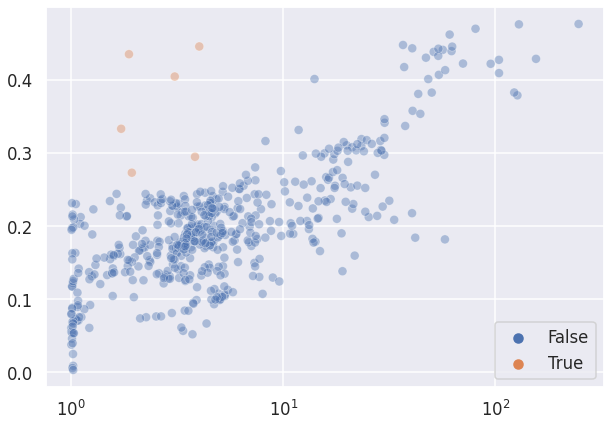

In [10]:
results = data_ed.copy()
results['outlier'] = results.apply(is_outlier, axis='columns')

_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=results, x='effective dimensionality', y='score', alpha=0.4, hue='outlier', ax=ax)
ax.set(xlabel=None, ylabel=None, xscale='log')
ax.legend(loc='lower right')

plt.show()

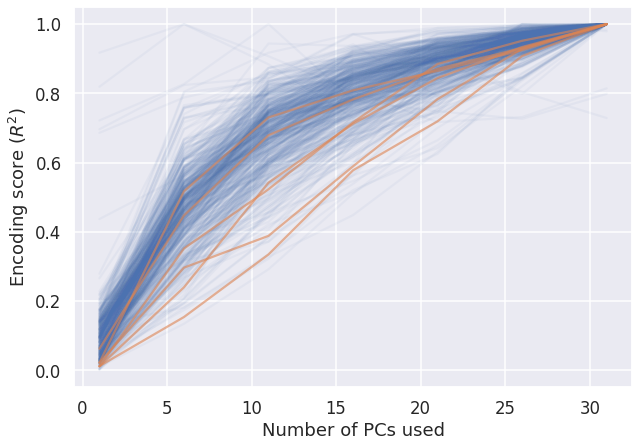

In [5]:
results = data.copy()
results['outlier'] = results.apply(is_outlier, axis='columns')
results['id'] = results[id_columns].sum(axis='columns')

_, ax = plt.subplots(figsize=(10, 7))
sns.lineplot(data=results[~results.outlier], x='num_pcs', y='scaled_scores',
             units='id', estimator=None, alpha=0.05, ax=ax)
sns.lineplot(data=results[results.outlier], x='num_pcs', y='scaled_scores',
             units='id', estimator=None, alpha=0.6, ax=ax)
ax.set(xlabel='Number of PCs used', ylabel=r'Encoding score ($R^2$)')

plt.show()